In [49]:
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from PIL import Image
from got10k.datasets import GOT10k
from pairwise import Pairwise
from siamfc import TrackerSiamFC
import matplotlib
import matplotlib.pyplot as plt
from got10k.utils.viz import show_frame
from torchvision import utils as vutils

%matplotlib inline

In [5]:
root_dir = 'data/'
seq_dataset = GOT10k(root_dir, subset='val')


pair_dataset = Pairwise(seq_dataset)

cuda = torch.cuda.is_available()
loader = DataLoader(
                pair_dataset, batch_size=8, shuffle=False,
                pin_memory=cuda, drop_last=False)

print("Loader Size: ", len(loader))


# itr = iter(loader)
batch = next(iter(loader))
# print("Batch Size: ", len(batch))
# print("Batch Item Shape: ", len(batch[0]))
# print("Batch Item Shape: ", len(batch[1]))

Loader Size:  2


In [78]:

from torchvision.transforms import Compose, CenterCrop, RandomCrop, ToTensor
from PIL import Image, ImageStat, ImageOps
from collections import namedtuple


class RandomStretch(object):

    def __init__(self, max_stretch=0.05, interpolation='bilinear'):
        assert interpolation in ['bilinear', 'bicubic']
        self.max_stretch = max_stretch
        self.interpolation = interpolation

    def __call__(self, img):
        scale = 1.0 + np.random.uniform(
            -self.max_stretch, self.max_stretch)
        size = np.round(np.array(img.size, float) * scale).astype(int)
        if self.interpolation == 'bilinear':
            method = Image.BILINEAR
        elif self.interpolation == 'bicubic':
            method = Image.BICUBIC
        return img.resize(tuple(size), method)


class SiamTransform:

    def __init__(self, **kargs):
#         super(Pairwise, self).__init__()
        self.cfg = self.parse_args(**kargs)

#         self.seq_dataset = seq_dataset
#         self.indices = np.random.permutation(len(seq_dataset))
        # augmentation for exemplar and instance images
        self.transform_z = Compose([
            RandomStretch(max_stretch=0.05),
            CenterCrop(self.cfg.instance_sz - 8),
            RandomCrop(self.cfg.instance_sz - 2 * 8),
            CenterCrop(self.cfg.exemplar_sz),
            ToTensor()])
        self.transform_x = Compose([
            RandomStretch(max_stretch=0.05),
            CenterCrop(self.cfg.instance_sz - 8),
            RandomCrop(self.cfg.instance_sz - 2 * 8),
            ToTensor()])

    def parse_args(self, **kargs):
        # default parameters
        cfg = {
            'pairs_per_seq': 10,
            'max_dist': 100,
            'exemplar_sz': 127,
            'instance_sz': 255,
            'context': 0.5}

        for key, val in kargs.items():
            if key in cfg:
                cfg.update({key: val})
        return namedtuple('GenericDict', cfg.keys())(**cfg)

    def transformPair(self, exemplar_image, instance_image, box):
        
#         index = self.indices[index % len(self.seq_dataset)]
#         img_files, anno = self.seq_dataset[index]
#         rand_z, rand_x = self._sample_pair(len(img_files))

#         exemplar_image = Image.open(img_files[rand_z])
#         instance_image = Image.open(img_files[rand_x])
        
        
        exemplar_image = self._crop_and_resize(exemplar_image, box)
        instance_image = self._crop_and_resize(instance_image, box)
        exemplar_image = 255.0 * self.transform_z(exemplar_image)
        instance_image = 255.0 * self.transform_x(instance_image)

        return exemplar_image, instance_image

    def __len__(self):
        return self.cfg.pairs_per_seq * len(self.seq_dataset)

    def _sample_pair(self, n):
        assert n > 0
        if n == 1:
            return 0, 0
        elif n == 2:
            return 0, 1
        else:
            max_dist = min(n - 1, self.cfg.max_dist)
            rand_dist = np.random.choice(max_dist) + 1
            rand_z = np.random.choice(n - rand_dist)
            rand_x = rand_z + rand_dist

        return rand_z, rand_x

    def _crop_and_resize(self, image, box):
        # convert box to 0-indexed and center based
        box = np.array([
            box[0] - 1 + (box[2] - 1) / 2,
            box[1] - 1 + (box[3] - 1) / 2,
            box[2], box[3]], dtype=np.float32)
        center, target_sz = box[:2], box[2:]

        # exemplar and search sizes
        context = self.cfg.context * np.sum(target_sz)
        z_sz = np.sqrt(np.prod(target_sz + context))
        x_sz = z_sz * self.cfg.instance_sz / self.cfg.exemplar_sz

        # convert box to corners (0-indexed)
        size = round(x_sz)
        corners = np.concatenate((
            np.round(center - (size - 1) / 2),
            np.round(center - (size - 1) / 2) + size))
        corners = np.round(corners).astype(int)

        # pad image if necessary
        pads = np.concatenate((
            -corners[:2], corners[2:] - image.size))
        npad = max(0, int(pads.max()))
        if npad > 0:
            avg_color = ImageStat.Stat(image).mean
            # PIL doesn't support float RGB image
            avg_color = tuple(int(round(c)) for c in avg_color)
            image = ImageOps.expand(image, border=npad, fill=avg_color)

        # crop image patch
        corners = tuple((corners + npad).astype(int))
        patch = image.crop(corners)

        # resize to instance_sz
        out_size = (self.cfg.instance_sz, self.cfg.instance_sz)
        patch = patch.resize(out_size, Image.BILINEAR)

        return patch





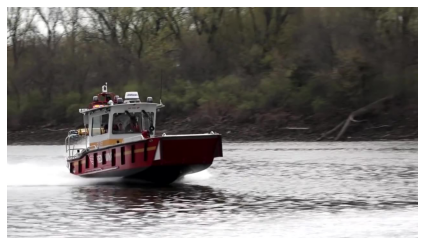

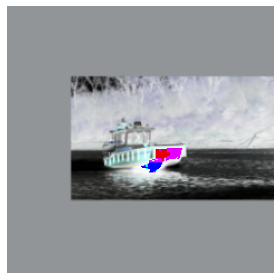

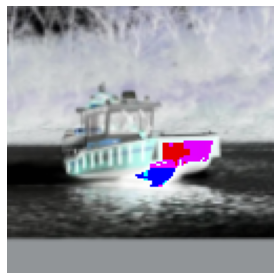

<Figure size 432x288 with 0 Axes>

In [82]:

img = Image.open('output/original_2.jpg')
show_frame(img)
siamTransform = SiamTransform()
# exemplar_image, instance_image = siamTransform.transformPair(img, img, [395.0,340.0,532.0,407.0])
exemplar_image, instance_image = siamTransform.transformPair(img, img, [181.0000,236.0000,489.0000,316.0000])

# type(exemplar_image)
to_pil = transforms.ToPILImage()
show_frame(to_pil(instance_image))
show_frame(to_pil(exemplar_image))


In [51]:
def showOriginalImages(dataset, max_iter=20):

    for s, (img_files, anno) in enumerate(dataset):
        seq_name = dataset.seq_names[s]
        print('Sequence:', seq_name)

        # show all frames
        for f, img_file in enumerate(img_files):
            image = Image.open(img_file)
            plt.imshow(image)
            plt.pause(0.001)

            if f >= max_iter:
                break
                
def showOriginalImagesIdx(dataset, idx):

    for s, (img_files, anno) in enumerate(dataset):
        seq_name = dataset.seq_names[s]
        print('Sequence:', seq_name)

        # show all frames
        for f, img_file in enumerate(img_files):
            
            if f in idx:
                image = Image.open(img_file)
                image.save(f"output/original_{f}.jpg")
                plt.imshow(image)
                plt.pause(0.001)


                
                
def getTrainImage(batch, seq='x', idx=0, show=True):
    
    if seq == 'x':
        images = batch[1]
    else:
        images = batch[0]
    
    print(f"{seq} batch shape: ", images.shape)
    
    img = images[idx]
    print(f"{seq} image shape: ", img.numpy().shape)
    
    to_pil = transforms.ToPILImage()
    to_pil(img).save(f"output/{seq}.jpg")
    
    if show:
        plt.imshow(to_pil(img))
        
    return img
    
    
def loadTrainWeight():
    tracker = TrackerSiamFC()
    net_dir = 'pretrained/siamfc'
    md = torch.load( f'{net_dir}/model.pth' )

    tracker.net.load_state_dict(md)

    return tracker

def getModuleLists(tracker):
    module_lists = list(tracker.net.feature.modules())
    print("Layers Length: ", len(module_lists))
    print("First Layer: ", module_lists[1])
    
    return module_lists[1:]

def getLayersOutput(img, module_lists):
    outputs = []
    names = []
#     img = x_img.unsqueeze(0)

    for layer in module_lists:
        img = layer(img)
        outputs.append(img)
        names.append(str(layer))
        
    return outputs, names

def printNetworkLayers(outputs):
    for feature_map in outputs:
        print(feature_map.shape)


def processData(outputs):
    processed = []
    for feature_map in outputs:
        feature_map = feature_map[0].squeeze(0)
        gray_scale = torch.sum(feature_map, 0)
        gray_scale = gray_scale / feature_map.shape[0]
        processed.append(gray_scale.data.cpu().numpy())
        
    return processed

def showLayersOutput(processed, names, seq):
    fig = plt.figure(figsize = (30, 50))

    for i in range(len(processed)):
        a = fig.add_subplot(8, 4, i+1)
        imgplot = plt.imshow(processed[i])
        plt.axis('off')
        fileName = f"output/{seq}_{i}.jpg"
        matplotlib.image.imsave(fileName, processed[i])
        a.set_title(names[i].split('(')[0], fontsize=30)
        
        
def calcCrossCorrelation(x_last, z_last, show=True, adjust=False):
    n, c, h, w = x_last.size()
    x_last = x_last.view(1, n * c, h, w)

    out = F.conv2d(x_last, z_last, groups=n)
    out = out.view(n, 1, out.size(-2), out.size(-1))
    
    if adjust:
        out = 0.001 * out + 0.0
    
    if show:
        plt.imshow(out.squeeze(0).squeeze(0).detach().numpy())

Sequence: GOT-10k_Val_000001


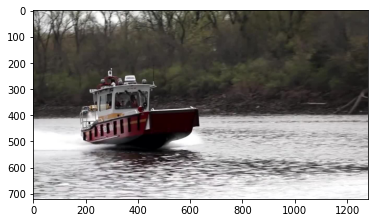

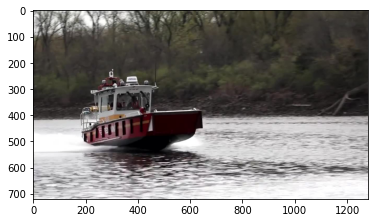

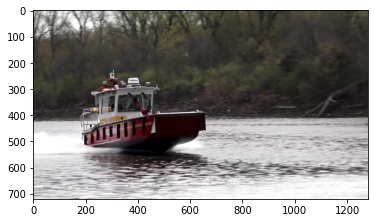

In [7]:
showOriginalImages(seq_dataset, 2)

Sequence: GOT-10k_Val_000001


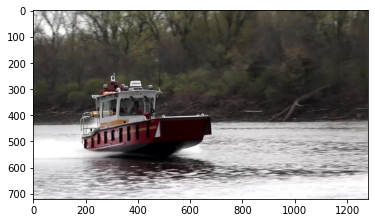

In [32]:
showOriginalImagesIdx(seq_dataset, [4])

x batch shape:  torch.Size([8, 3, 239, 239])
x image shape:  (3, 239, 239)


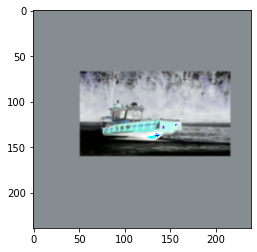

In [52]:
x_img = getTrainImage(batch, seq='x', idx=4, show=True)

z batch shape:  torch.Size([8, 3, 127, 127])
z image shape:  (3, 127, 127)


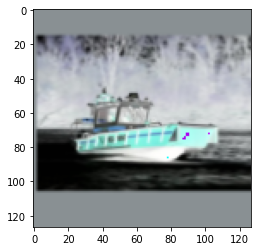

In [30]:
z_img = getTrainImage(batch, seq='z', idx=4, show=True)

In [85]:
tracker = loadTrainWeight()
module_lists = getModuleLists(tracker)

print(type(x_img.unsqueeze(0)))

x_outputs, x_names = getLayersOutput(x_img.unsqueeze(0), module_lists)
z_outputs, z_names = getLayersOutput(z_img.unsqueeze(0), module_lists)

x_pro = processData(x_outputs)
z_pro = processData(z_outputs)

Layers Length:  16
First Layer:  Conv2d(3, 96, kernel_size=(11, 11), stride=(2, 2))
<class 'torch.Tensor'>


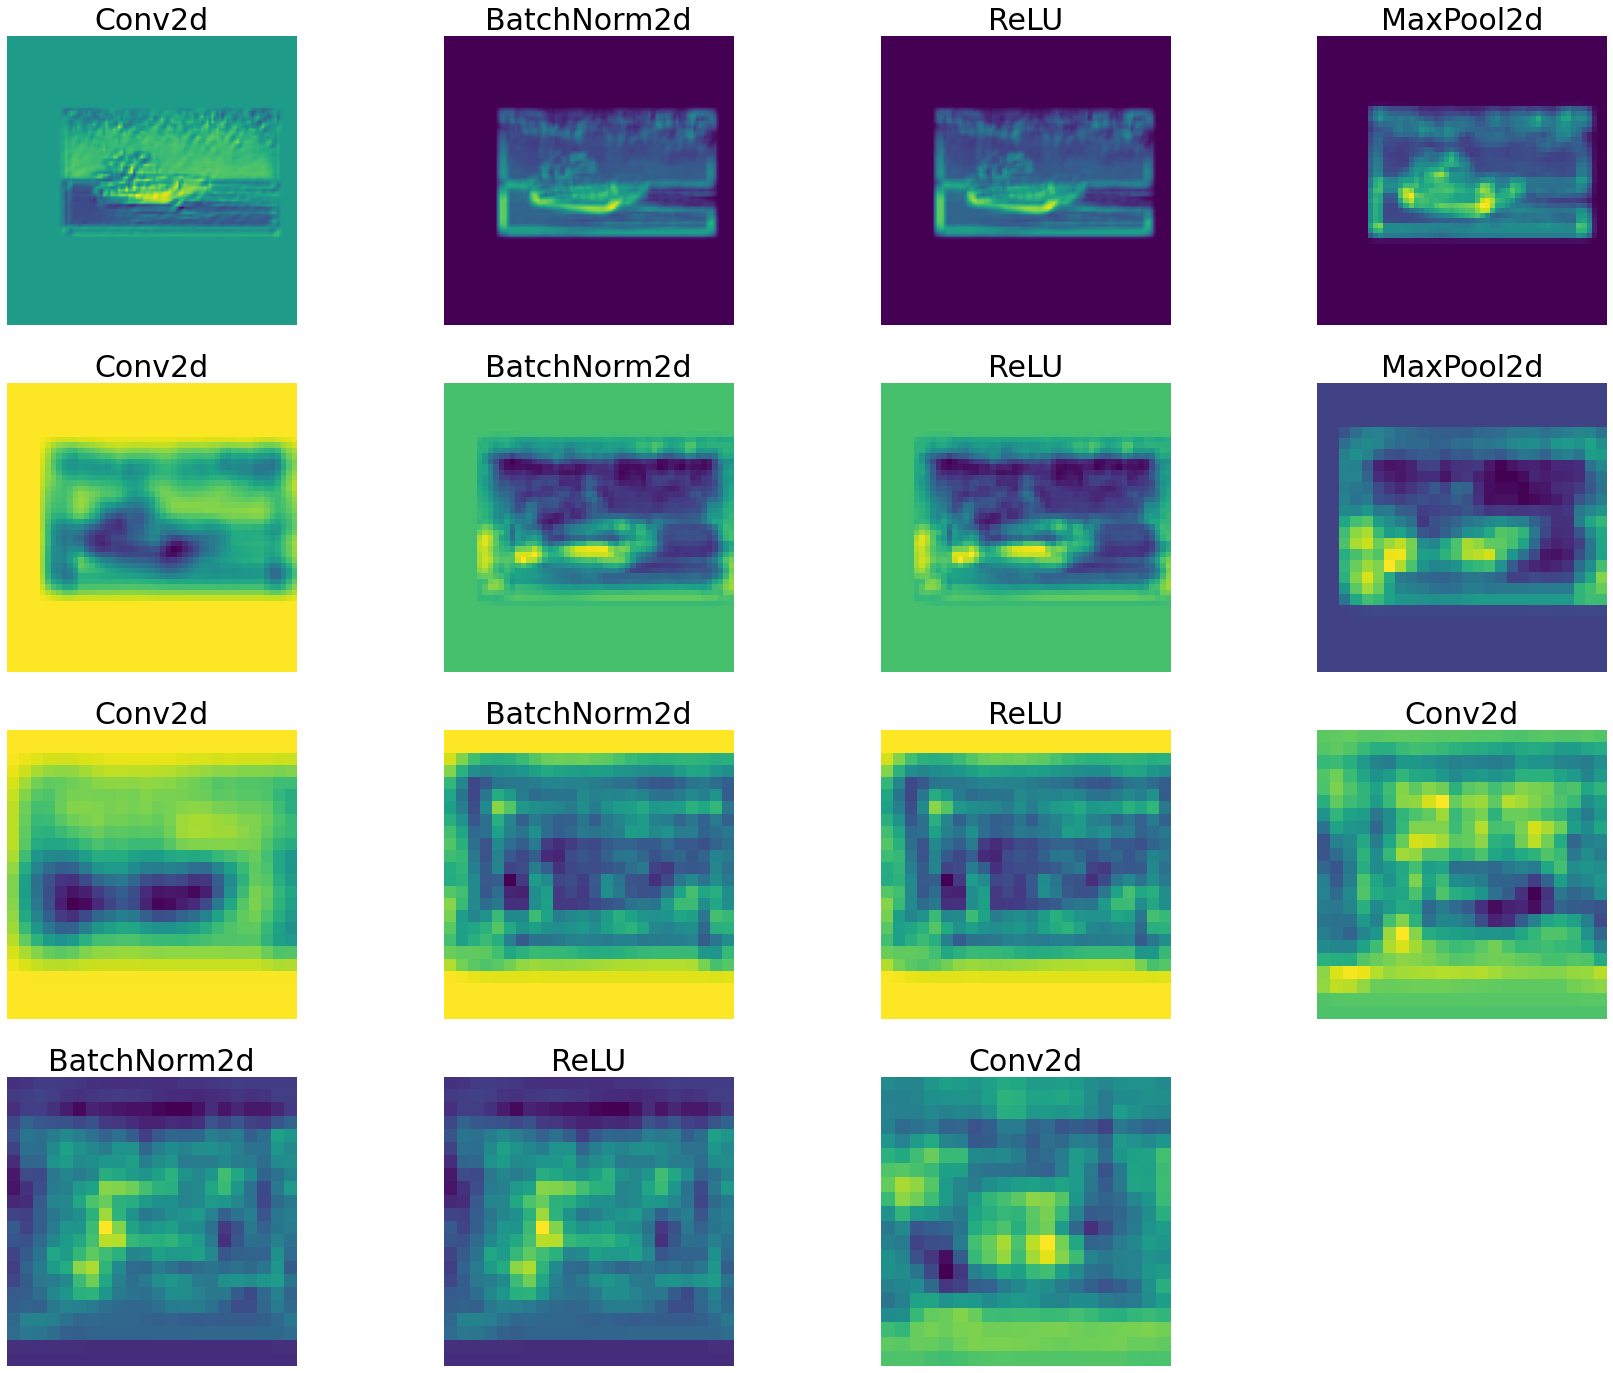

In [53]:
showLayersOutput(x_pro, x_names, seq='x')

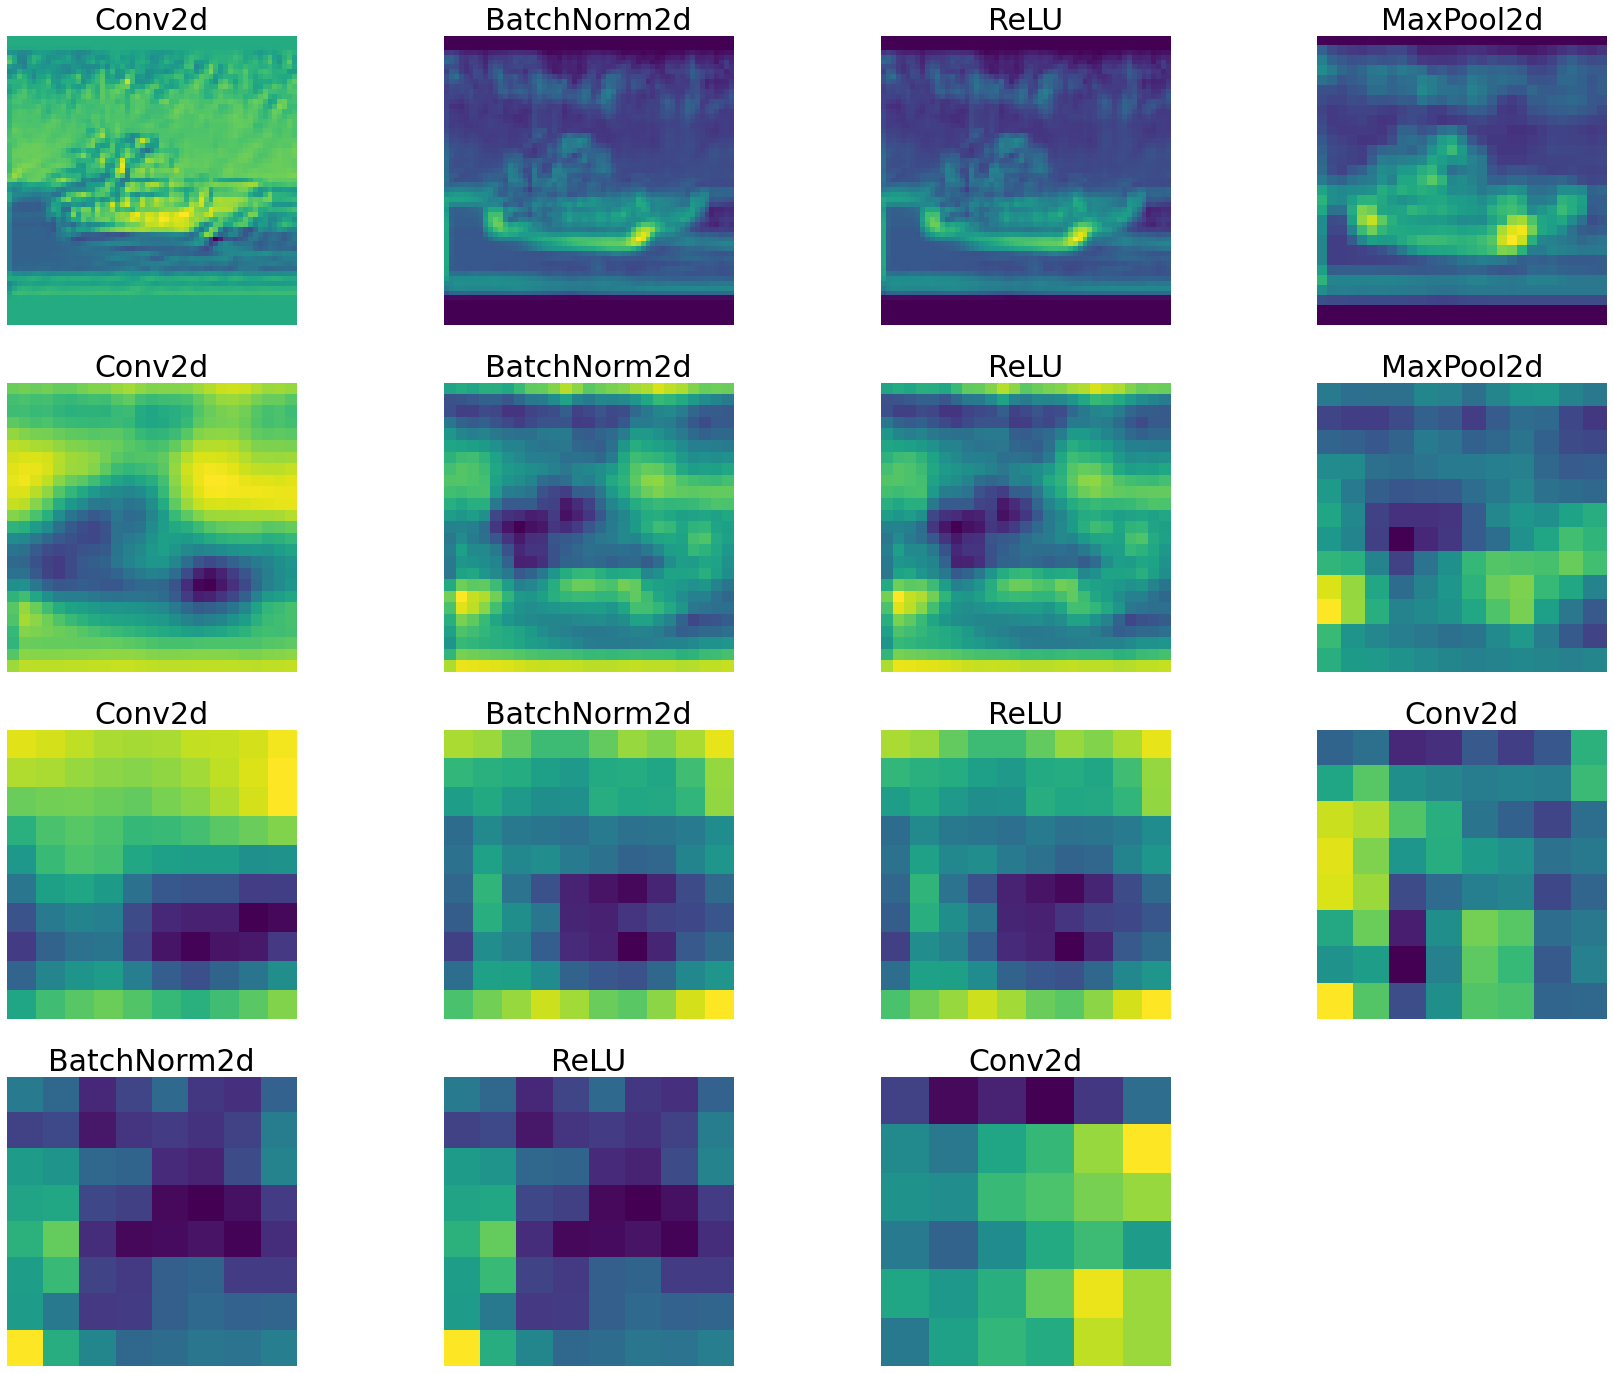

In [54]:
showLayersOutput(z_pro, z_names, seq='z')

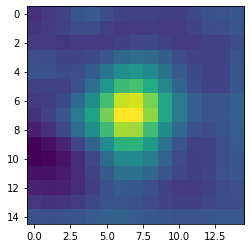

In [17]:
calcCrossCorrelation(x_outputs[-1], z_outputs[-1])

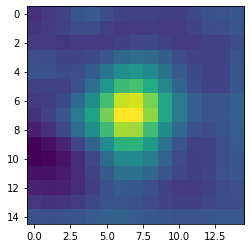

In [18]:
calcCrossCorrelation(x_outputs[-1], z_outputs[-1], adjust=True)